### Загружаем необходимые библиотеки

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt

### Загружаем данные и визуализируем их

In [2]:
sales = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')
sales.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

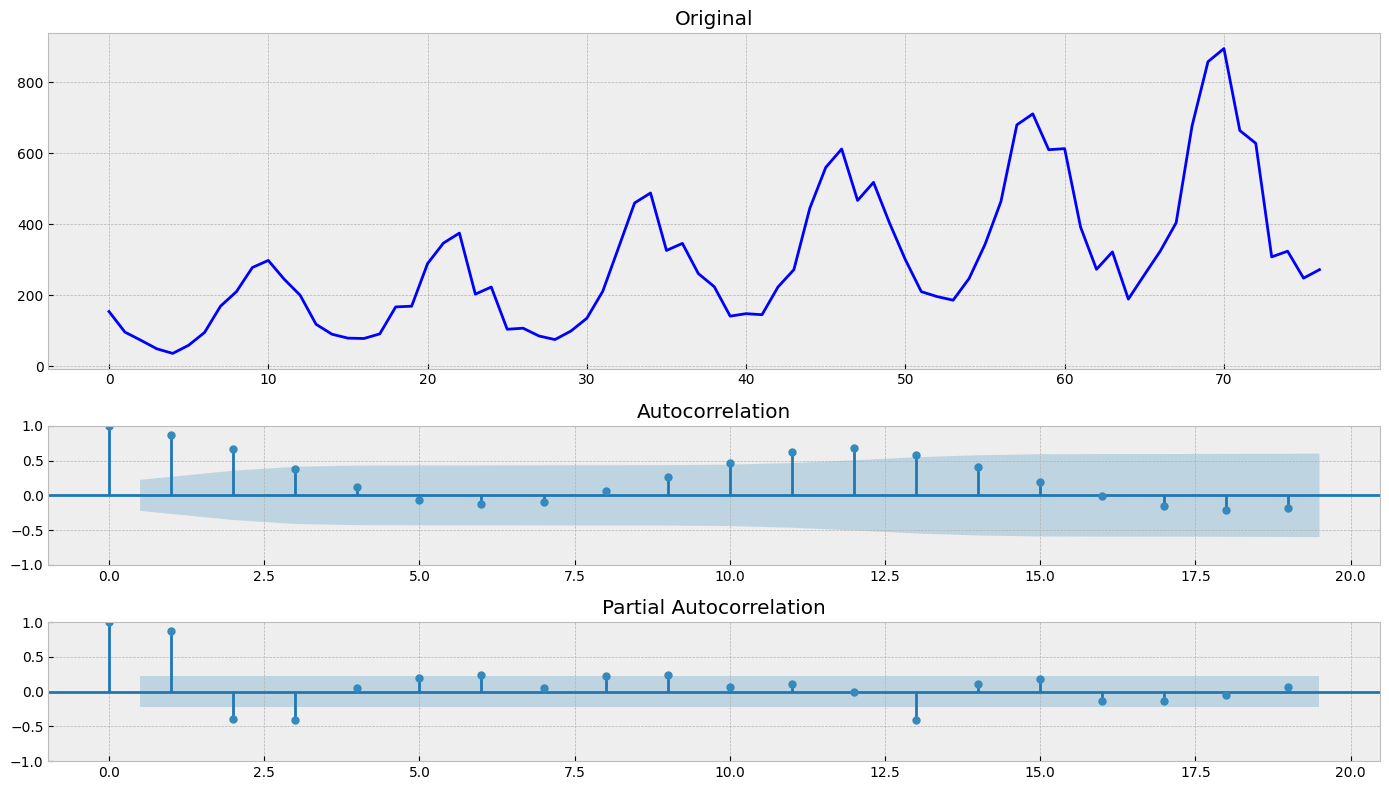

In [5]:
tsplot(sales['Count'])

Временной ряд нестационарен, в нем наблюдается сезонность и восходящий тренд

### Проведем SSA данных с разной длинной окна

Для реализации SAA используем одноименный класс, представленный на Kaggle

Ссылка: https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition

In [6]:
class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.

        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """

        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)


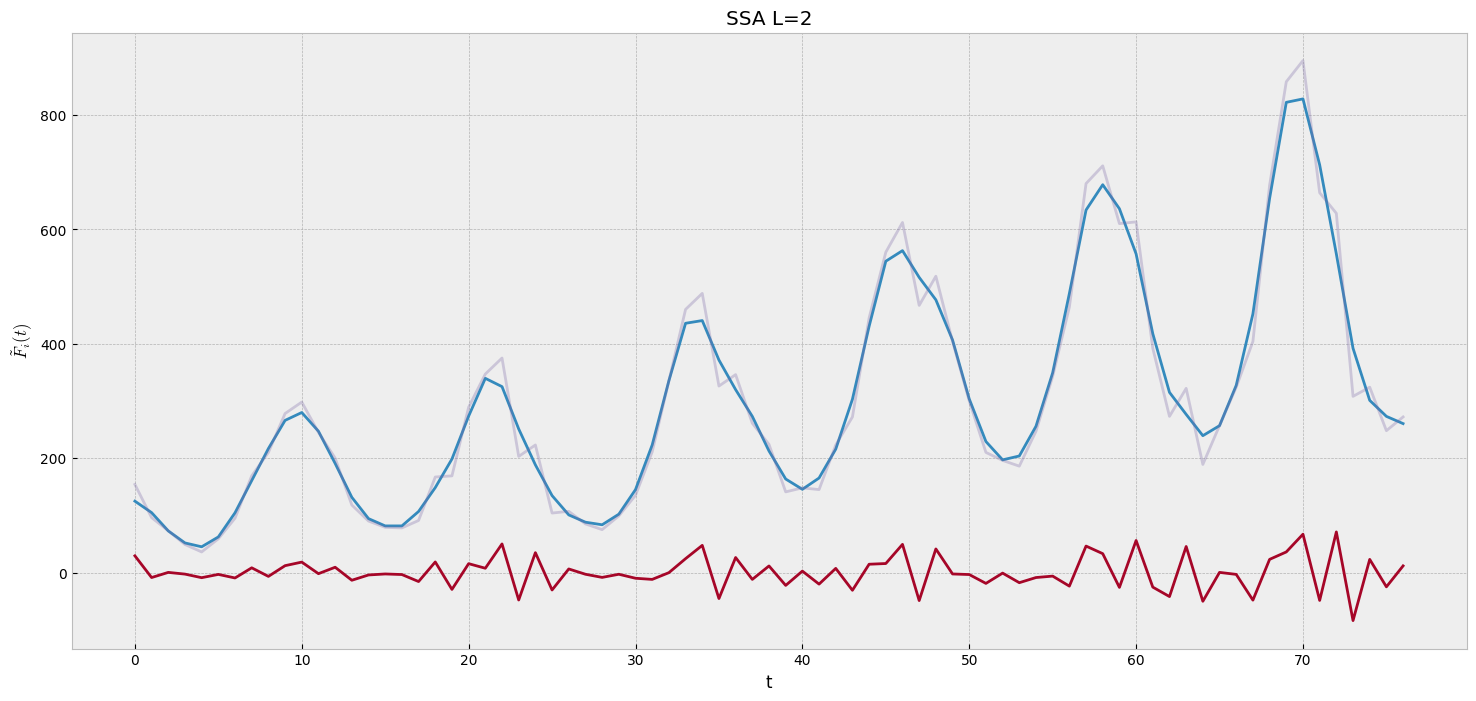

In [22]:
#SSA с длинной окна равной 2
ssa_L2 = SSA(sales['Count'], 2)
ssa_L2 = ssa_L2.components_to_df()
with plt.style.context('bmh'):
  plt.figure(figsize=(18, 8))
  plt.plot(ssa_L2)
  plt.plot(sales['Count'], alpha=0.3)
  plt.title('SSA L=2')
  plt.xlabel('t')
  plt.ylabel(r'$\tilde{F}_i(t)$')

При длине окна равной 2 от основого массива данных отделился канал с шумом

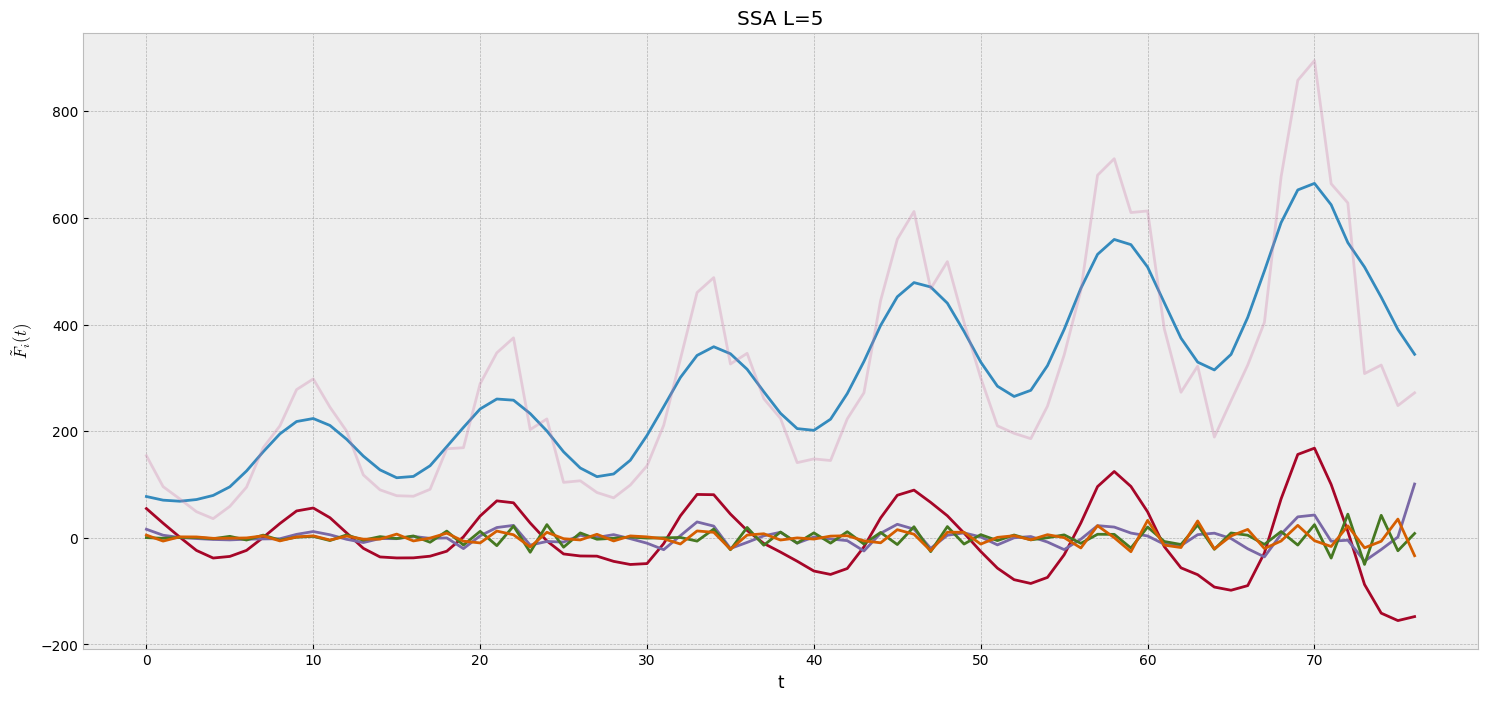

In [25]:
#SSA с длинной окна равной 5
ssa_L5 = SSA(sales['Count'], 5)
ssa_L5 = ssa_L5.components_to_df()
with plt.style.context('bmh'):
  plt.figure(figsize=(18, 8))
  plt.plot(ssa_L5)
  plt.plot(sales['Count'], alpha=0.3)
  plt.title('SSA L=5')
  plt.xlabel('t')
  plt.ylabel(r'$\tilde{F}_i(t)$')

При длине окна равной 5 помимо каналов с шумом наблюдается канал, отражающий сезонность, и канал, отражающий сезонность и тренд

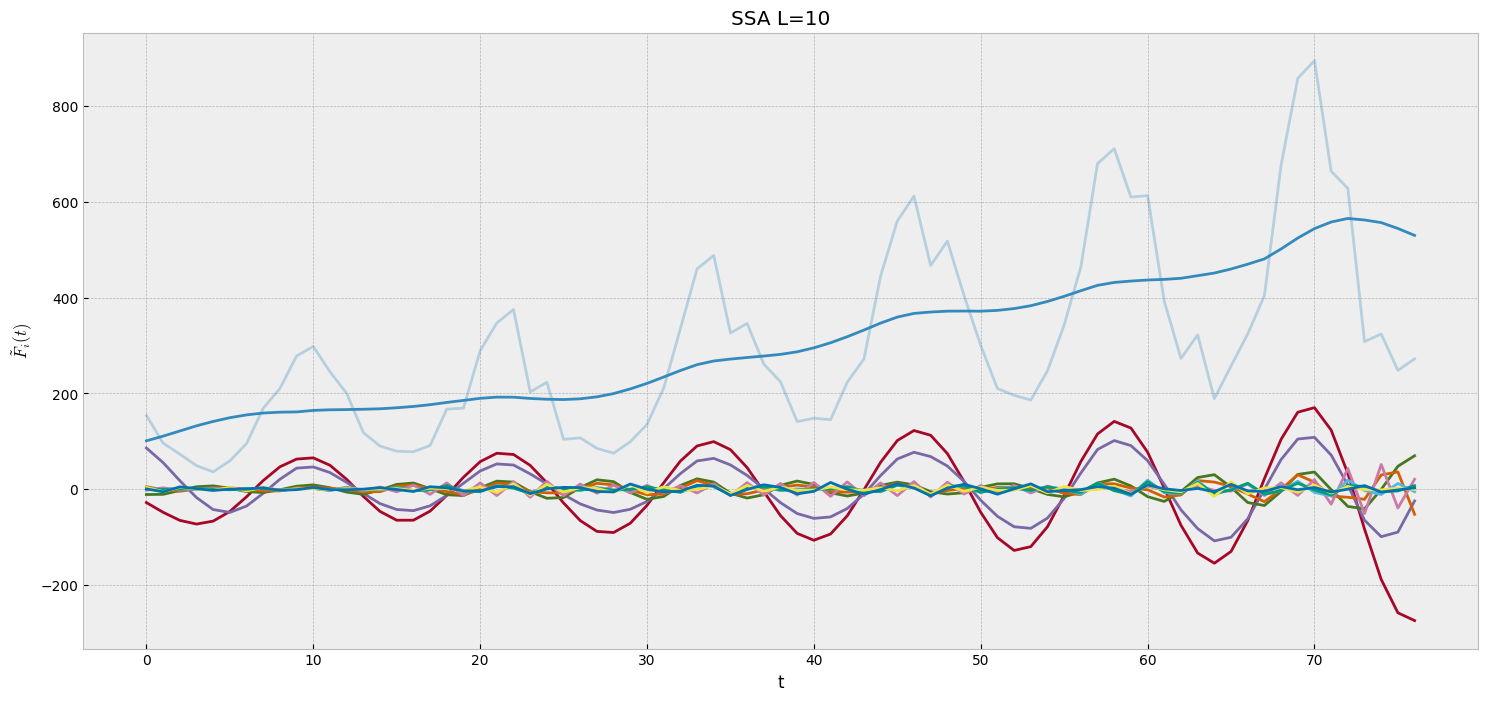

In [26]:
#SSA с длинной окна равной 10
ssa_L10 = SSA(sales['Count'], 10)
ssa_L10 = ssa_L10.components_to_df()
with plt.style.context('bmh'):
  plt.figure(figsize=(18, 8))
  plt.plot(ssa_L10)
  plt.plot(sales['Count'], alpha=0.3)
  plt.title('SSA L=10')
  plt.xlabel('t')
  plt.ylabel(r'$\tilde{F}_i(t)$')

При длине окна равной 10 помимо каналов с шумом наблюдаются 2 канала, отражающих сезонность, и канал, отражающий тренд

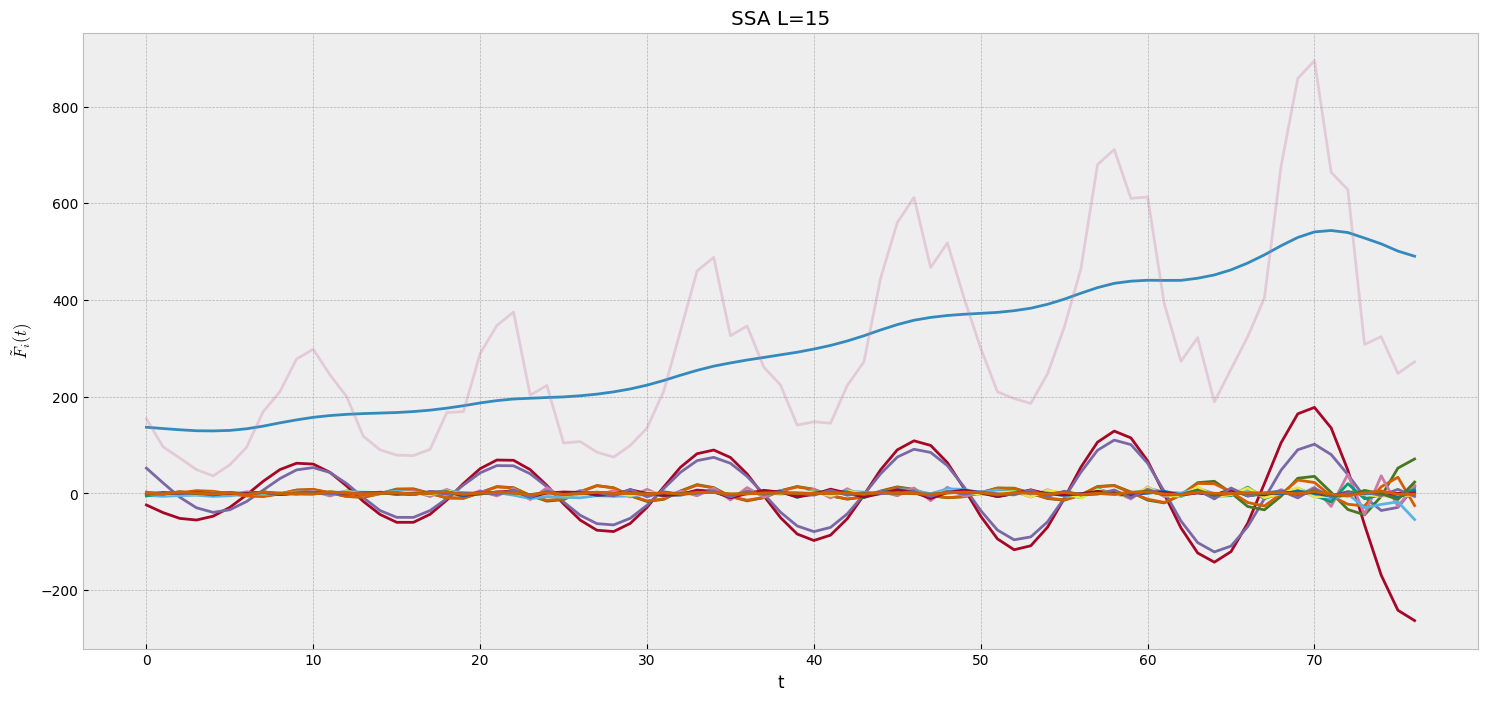

In [29]:
#SSA с длинной окна равной 15
ssa_L15 = SSA(sales['Count'], 15)
ssa_L15 = ssa_L15.components_to_df()
with plt.style.context('bmh'):
  plt.figure(figsize=(18, 8))
  plt.plot(ssa_L15)
  plt.plot(sales['Count'], alpha=0.3)
  plt.title('SSA L=15')
  plt.xlabel('t')
  plt.ylabel(r'$\tilde{F}_i(t)$')

При увеличении длины окна с 10 до 15 не наблюдается увеличения количества нешумовых каналов

### Найдем оптимальную длину окна

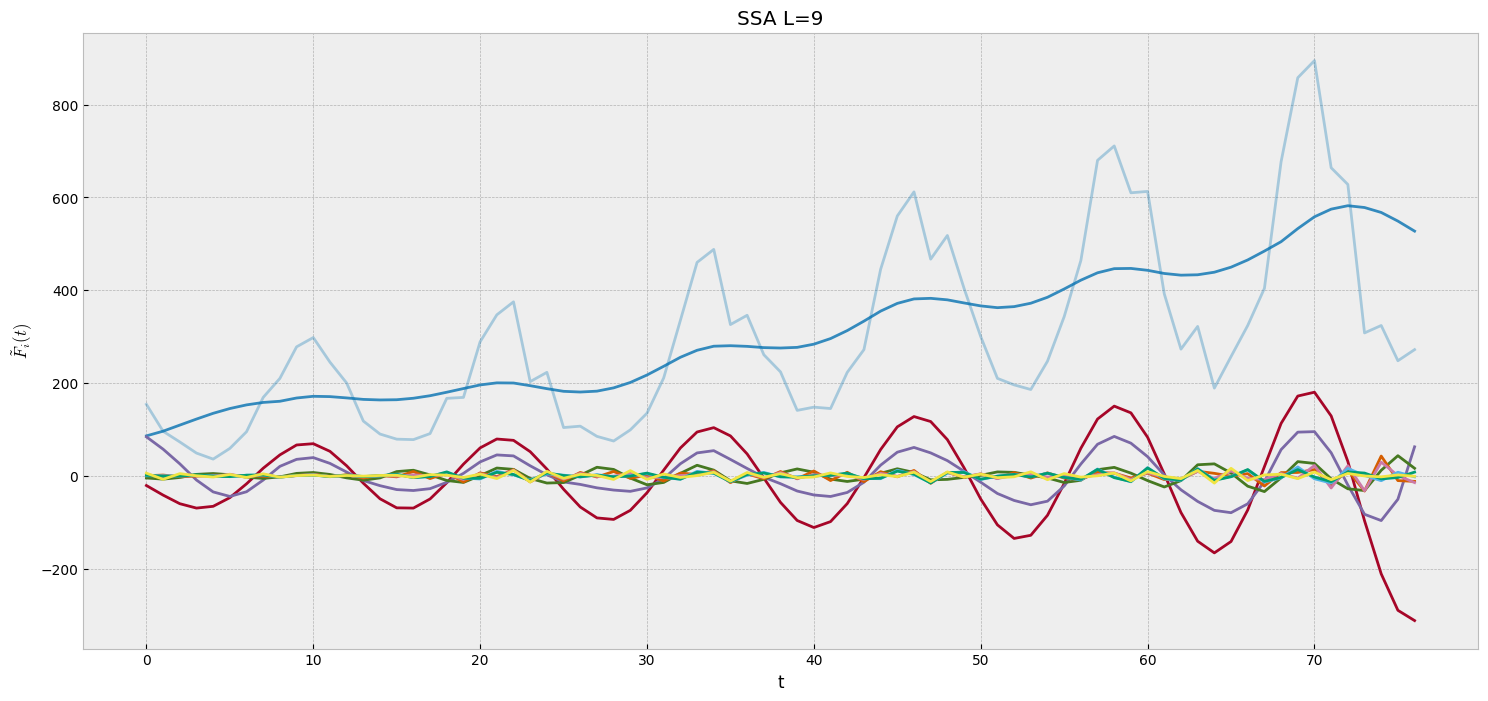

In [45]:
#SSA с длинной окна равной 9
ssa_L9 = SSA(sales['Count'], 9)
ssa_L9 = ssa_L9.components_to_df()
with plt.style.context('bmh'):
  plt.figure(figsize=(18, 8))
  plt.plot(ssa_L9)
  plt.plot(sales['Count'], alpha=0.3)
  plt.title('SSA L=9')
  plt.xlabel('t')
  plt.ylabel(r'$\tilde{F}_i(t)$')

При длине окна равной 9 канал тренда начинает включать в себя сезонность

Оптимальным размером окна SSA для данного временного ряда является длина окна равная 10, так как это минимальное значение при котором четко отделяются друг от друга все нешумовые каналы данного временного ряда